# Results

In [1]:
# Data Processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# Evaluation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox


In [2]:
base_path_plots = "/Users/Vageli/Desktop/DABN01/plots/Results/"

## Plot Functions

### Predictions

In [3]:
def plot_predictions(datetime_series, y_true, y_pred,
                     filename,
                     color,
                     linestyle="solid", 
                     base_path=base_path_plots):
    
    # Full save path
    save_path = f"{base_path}{filename}.png"
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(datetime_series, y_true, label='Actual', linewidth=2)
    ax.plot(datetime_series, y_pred, label='Predicted', color=color, linestyle=linestyle, linewidth=2)
    

    ax.set_ylabel("Energy (kW)")
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right')
    
    fig.autofmt_xdate()  # Auto-format date labels
    plt.tight_layout()
    
    # Save figure
    fig.savefig(save_path, dpi=300)
    plt.show()

### Weekly Predicitons

In [93]:
def plot_weekly_predictions(datetime_series, y_true, y_pred, 
                            filename, 
                            color,
                            linestyle="solid",
                            base_path=base_path_plots):
    
    # Full save path
    save_path = f"{base_path}{filename}.png"

    # Define the fixed weeks (start and end dates in 2024)
    week_ranges = [
        ('2024-03-11', '2024-03-17'),
        ('2024-05-06', '2024-05-12'),
        ('2024-06-24', '2024-06-30'),
        ('2024-07-08', '2024-07-14'),
        ('2024-08-19', '2024-08-25'),
        ('2024-09-02', '2024-09-08'),
        ('2024-10-21', '2024-10-27'),
        ('2024-11-11', '2024-11-17'),
        ('2024-12-09', '2024-12-15')
    ]
    
    # Convert dates to timestamps with timezone matching your data
    tz = datetime_series.tz
    week_ranges = [(pd.Timestamp(start).tz_localize(tz), pd.Timestamp(end).tz_localize(tz)) for start, end in week_ranges]

    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharey=True)

    for idx, (ax, (start_date, end_date)) in enumerate(zip(axes.flatten(), week_ranges)):
        mask = (datetime_series >= start_date) & (datetime_series <= end_date)

        # Plot actual and predicted
        ax.plot(datetime_series[mask], y_true[mask], label='Actual', linewidth=2)
        ax.plot(datetime_series[mask], y_pred[mask], label='Predicted', color=color, linestyle=linestyle, linewidth=2)
        ax.set_title(f'Week: {start_date.date()} to {end_date.date()}', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.tick_params(axis='x', labelrotation=45)

        ax.set_xlim(start_date, end_date)

        # Add axis labels based on row/column positions
        row, col = divmod(idx, 3)
        if col == 0:
            ax.set_ylabel('Energy (kW)', fontsize=10)

    fig.legend(['Actual', 'Predicted'], loc='upper center', ncol=2, fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save figure
    fig.savefig(save_path, dpi=300)
    plt.show()

### Residual Analysis

In [5]:
def plot_residuals(datetime_series, y_true, y_pred, 
                   filename, 
                   base_path=base_path_plots):
    
     # Full save path
    save_path = f"{base_path}{filename}.png"

    # Calculate residuals
    residuals = y_true - y_pred

    # Create plot
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1.5])

    # Residuals over time
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(datetime_series, residuals, color='steelblue')
    ax1.axhline(0, linestyle='--', color='gray')
    ax1.set_ylabel("Residual (kW)")
    ax1.grid(True, linestyle='--', alpha=0.6)

    # ACF
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_ylabel("ACF")
    plot_acf(residuals, lags=1344, ax=ax2)

    # Histogram
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.set_ylabel("Count")
    sns.histplot(residuals, bins=30, kde=True, color='salmon', ax=ax3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

## LightGBM

### Test-time

In [6]:
results_lgbm_test = pd.read_csv(
    '/Users/Vageli/Downloads/Results/LightGBM_impute_test/predicitions_lgbm_test.csv',
    sep=',',
    decimal='.',
    index_col=0,
    parse_dates=True
)

results_lgbm_test.index = pd.to_datetime(results_lgbm_test.index, utc=True)

datetime_lgbm_test = results_lgbm_test.index
true_lgbm_test = results_lgbm_test['true']
pred_lgbm_test = results_lgbm_test['prediction']

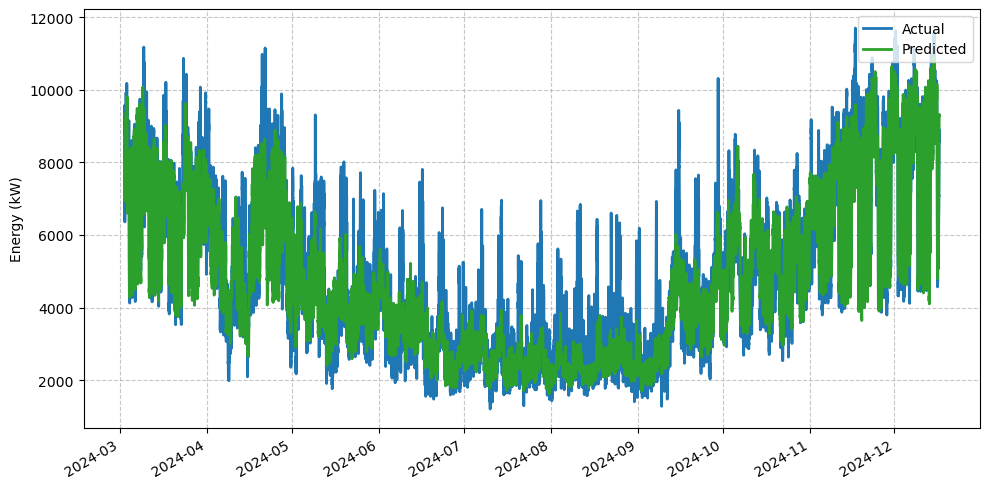

In [27]:
plot_predictions(datetime_lgbm_test,
                 true_lgbm_test,
                 pred_lgbm_test, 
                 color="tab:green",
                 filename="predicitons(model=lgbm,set=test)")

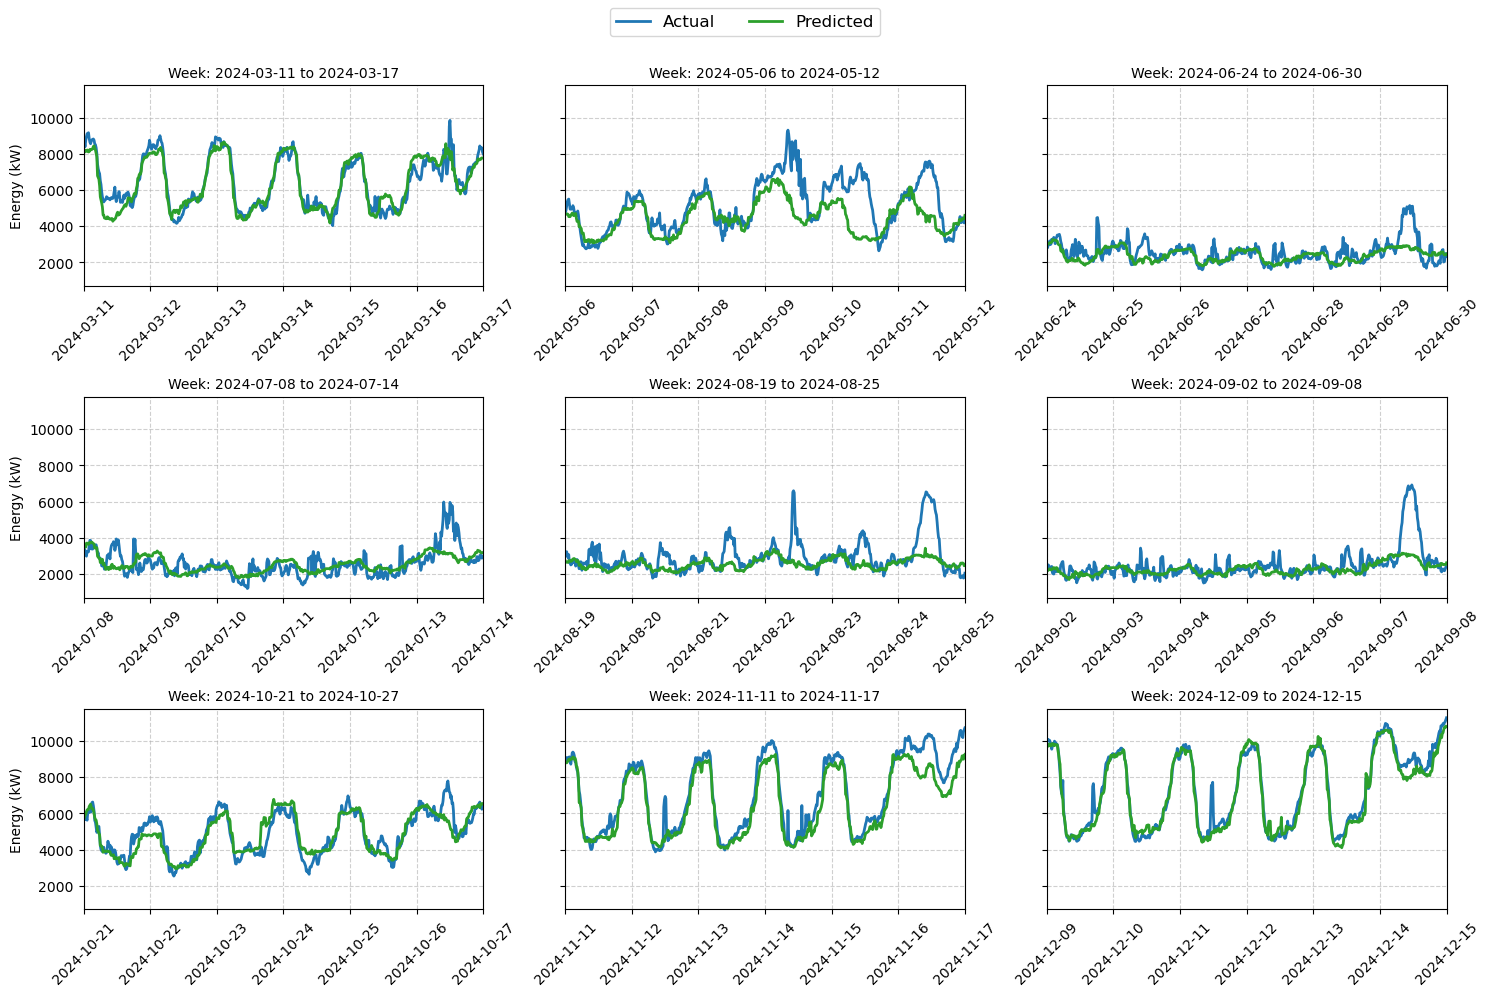

In [94]:
plot_weekly_predictions(datetime_lgbm_test,
                        true_lgbm_test,
                        pred_lgbm_test, 
                        color="tab:green",
                        filename="weekly_intervals(model=lgbm,set=test)")

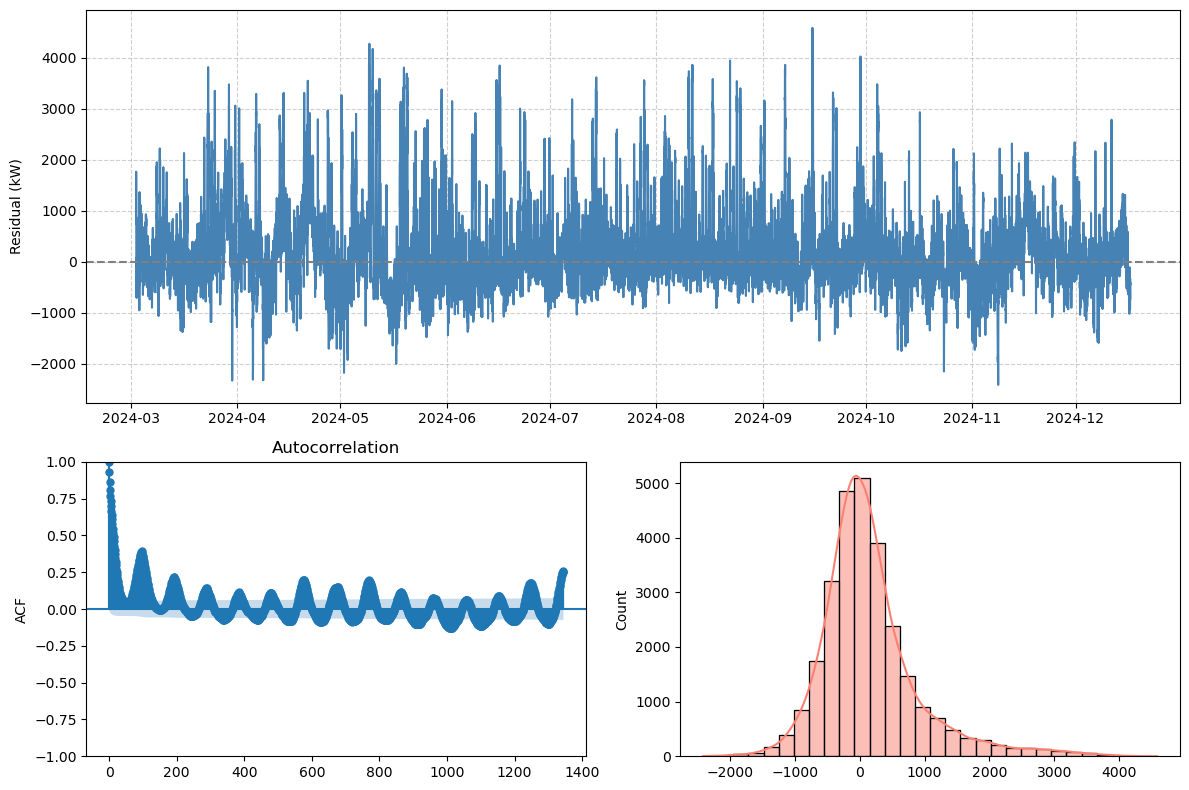

In [9]:
plot_residuals(datetime_lgbm_test,
               true_lgbm_test,
               pred_lgbm_test, 
               filename="residuals(model=lgbm,set=test)")

In [10]:
residuals_lgbm_test = true_lgbm_test - pred_lgbm_test
print(acorr_ljungbox(residuals_lgbm_test, lags=[192, 1344], return_df=True))

            lb_stat  lb_pvalue
192   333149.869833        0.0
1344  554791.881549        0.0


### Train-time

In [11]:
results_lgbm_all = pd.read_csv(
    '/Users/Vageli/Downloads/Results/LightGBM_impute_all/predicitions_lgbm_all.csv',
    sep=',',
    decimal='.',
    index_col=0,
    parse_dates=True
)

results_lgbm_all.index = pd.to_datetime(results_lgbm_all.index, utc=True)

datetime_lgbm_all = results_lgbm_all.index
true_lgbm_all = results_lgbm_all['true']
pred_lgbm_all = results_lgbm_all['prediction']

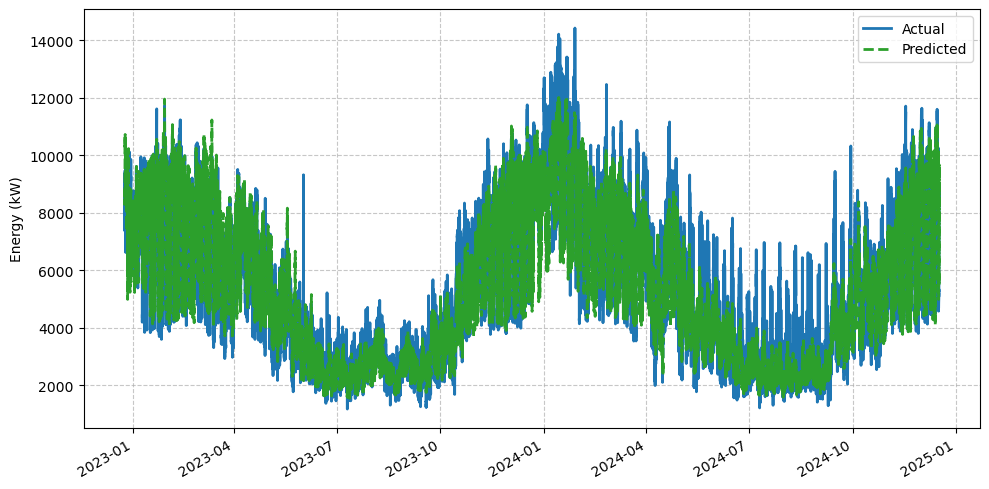

In [29]:
plot_predictions(datetime_lgbm_all,
                 true_lgbm_all,
                 pred_lgbm_all, 
                 color="tab:green",
                 linestyle="dashed",
                 filename="predicitons(model=lgbm,set=all)")

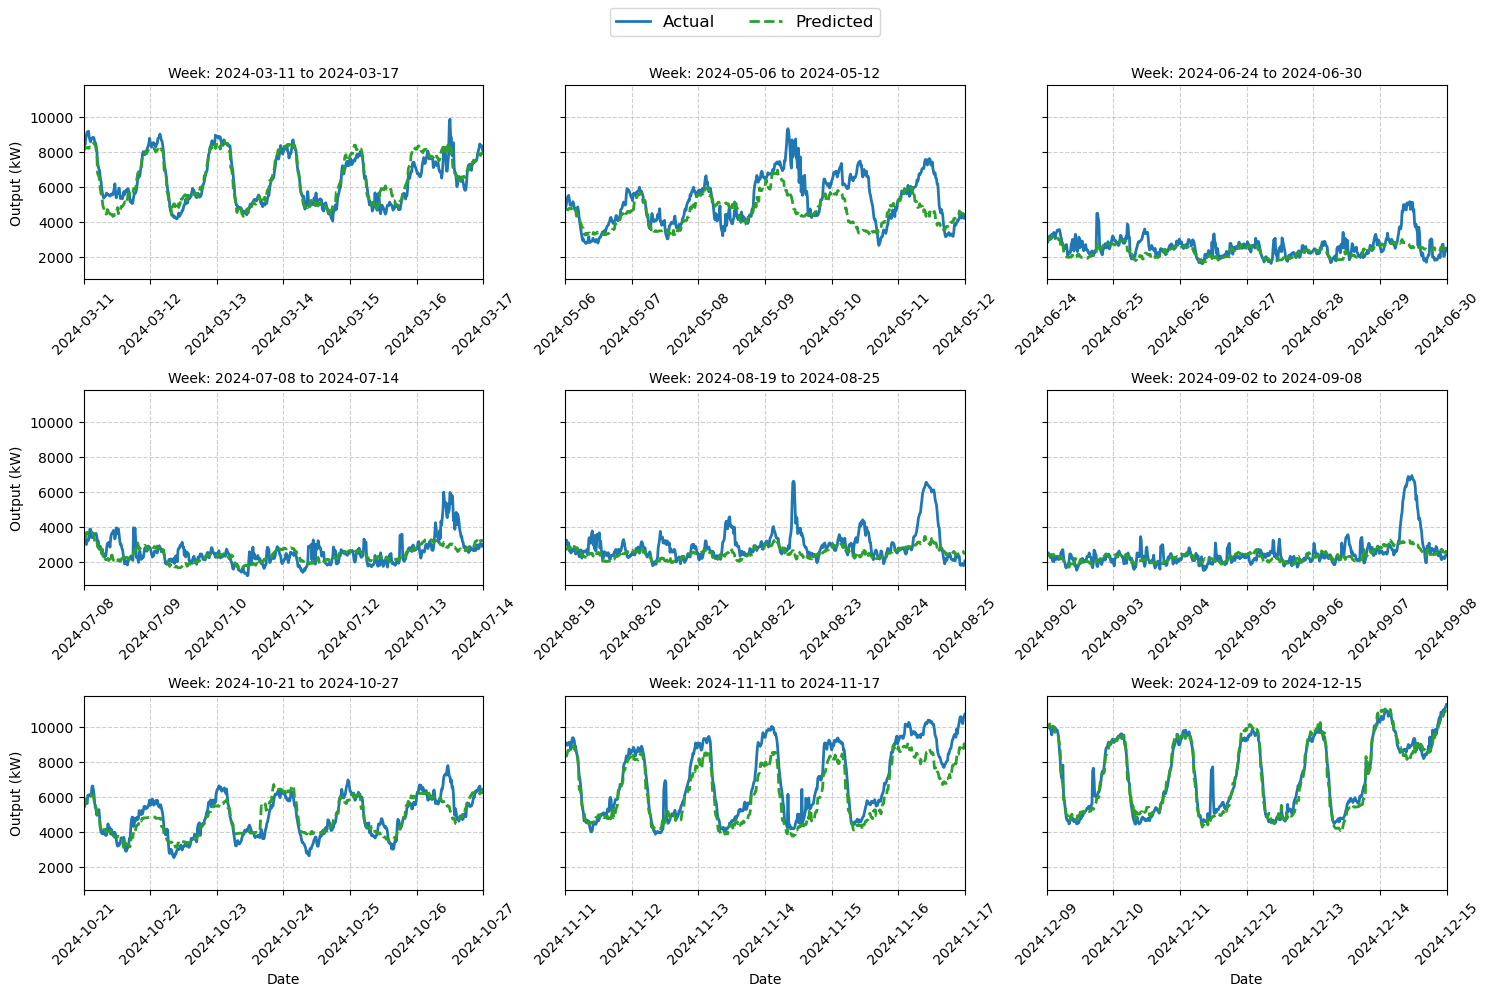

In [30]:
plot_weekly_predictions(datetime_lgbm_all,
                        true_lgbm_all,
                        pred_lgbm_all, 
                        color="tab:green",
                        linestyle="dashed",
                        filename="weekly_intervals(model=lgbm,set=all)")

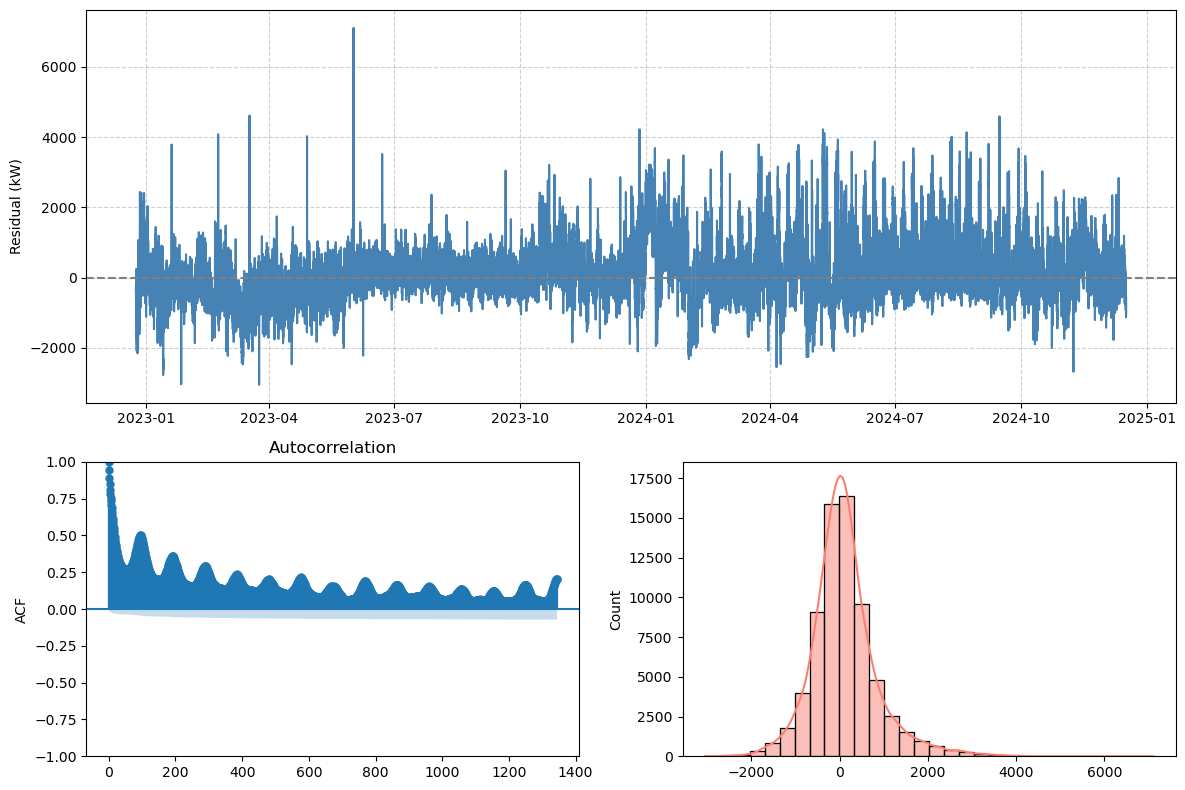

In [15]:
plot_residuals(datetime_lgbm_all,
               true_lgbm_all,
               pred_lgbm_all, 
               filename="residuals(model=lgbm,set=all)")

In [16]:
residuals_lgbm_all = true_lgbm_all - pred_lgbm_all
print(acorr_ljungbox(residuals_lgbm_all, lags=[192, 1344], return_df=True))

           lb_stat  lb_pvalue
192   1.836262e+06        0.0
1344  3.284796e+06        0.0


## LSTM

### Test-time

In [17]:
results_lstm_test = pd.read_csv(
    '/Users/Vageli/Downloads/Results/LSTM_impute_test/predicitions_lstm_test.csv',
    sep=',',
    decimal='.',
    index_col=0,
    parse_dates=True
)

results_lstm_test.index = pd.to_datetime(results_lstm_test.index, utc=True)

datetime_lstm_test = results_lstm_test.index
true_lstm_test = results_lstm_test['true']
pred_lstm_test = results_lstm_test['prediction']

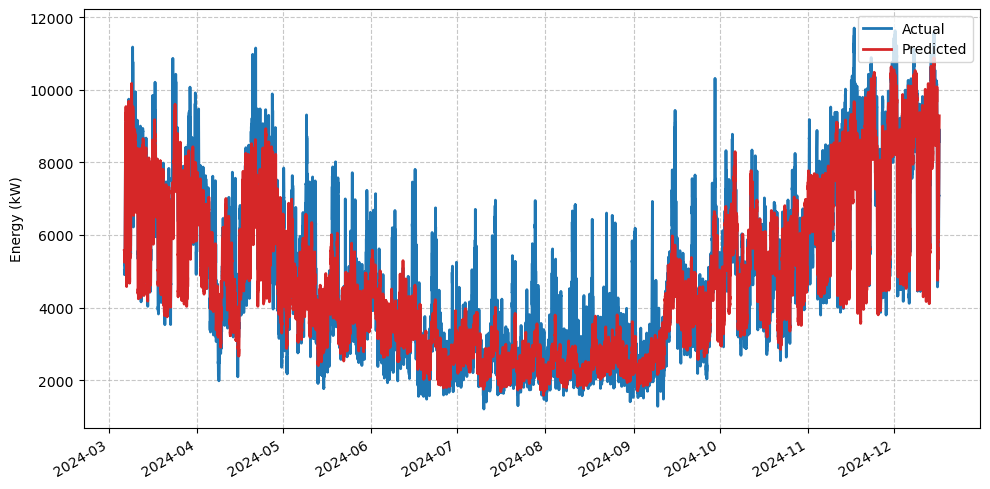

In [18]:
plot_predictions(datetime_lstm_test,
                 true_lstm_test,
                 pred_lstm_test, 
                 color="tab:red",
                 filename="predicitons(model=lstm,set=test)")

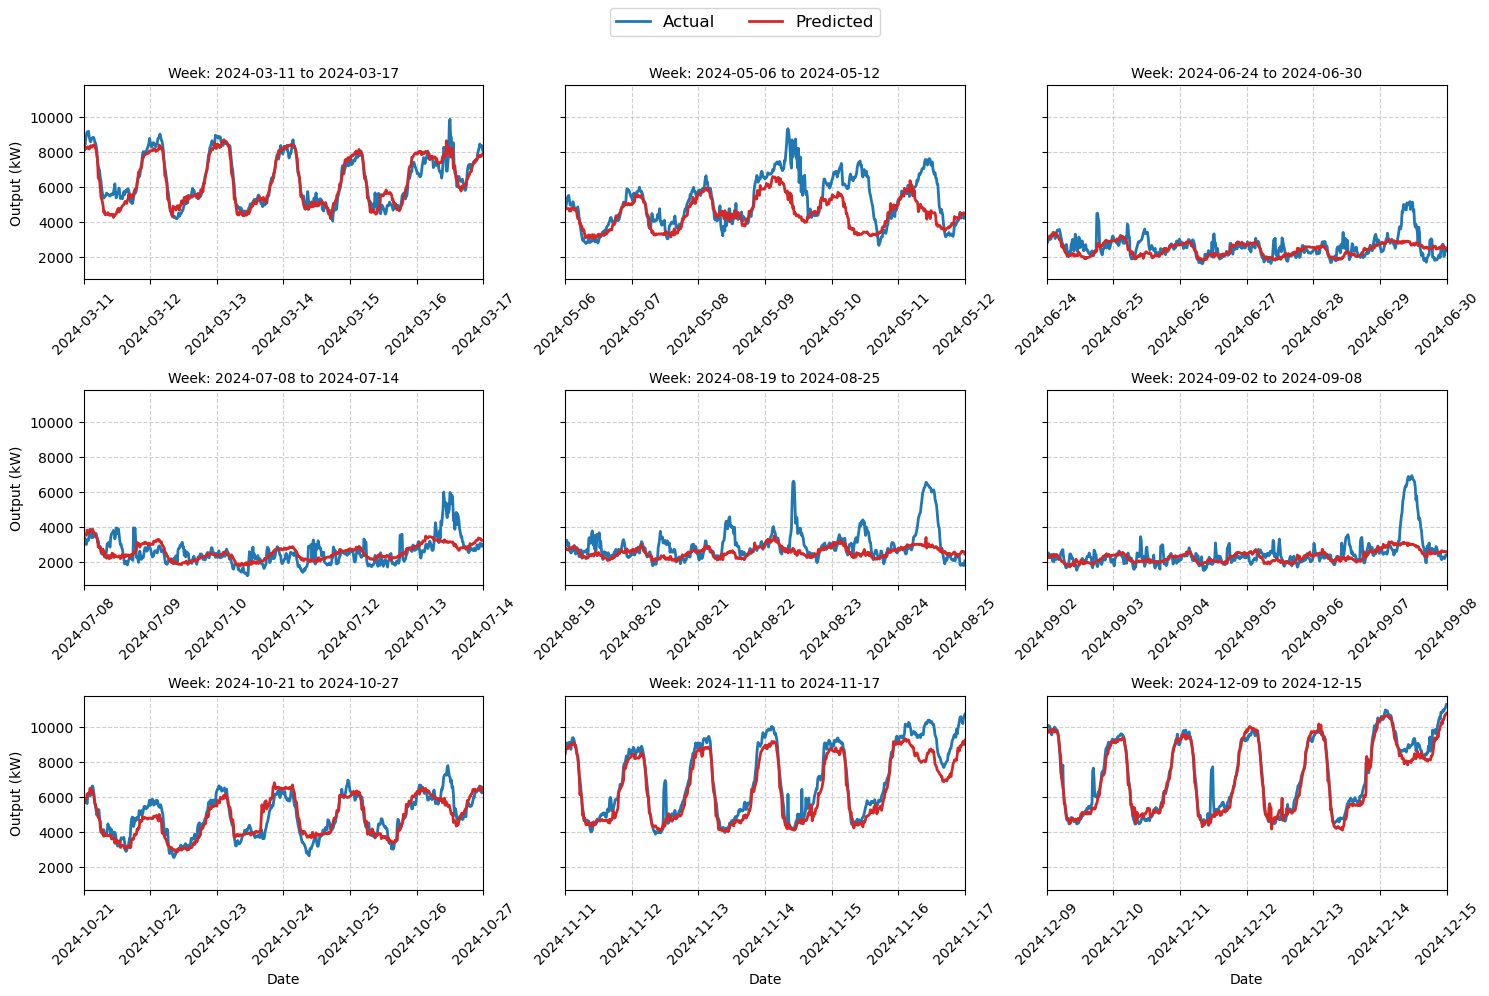

In [19]:
plot_weekly_predictions(datetime_lstm_test,
                        true_lstm_test,
                        pred_lstm_test, 
                        color="tab:red",
                        filename="weekly_intervals(model=lstm,set=test)")

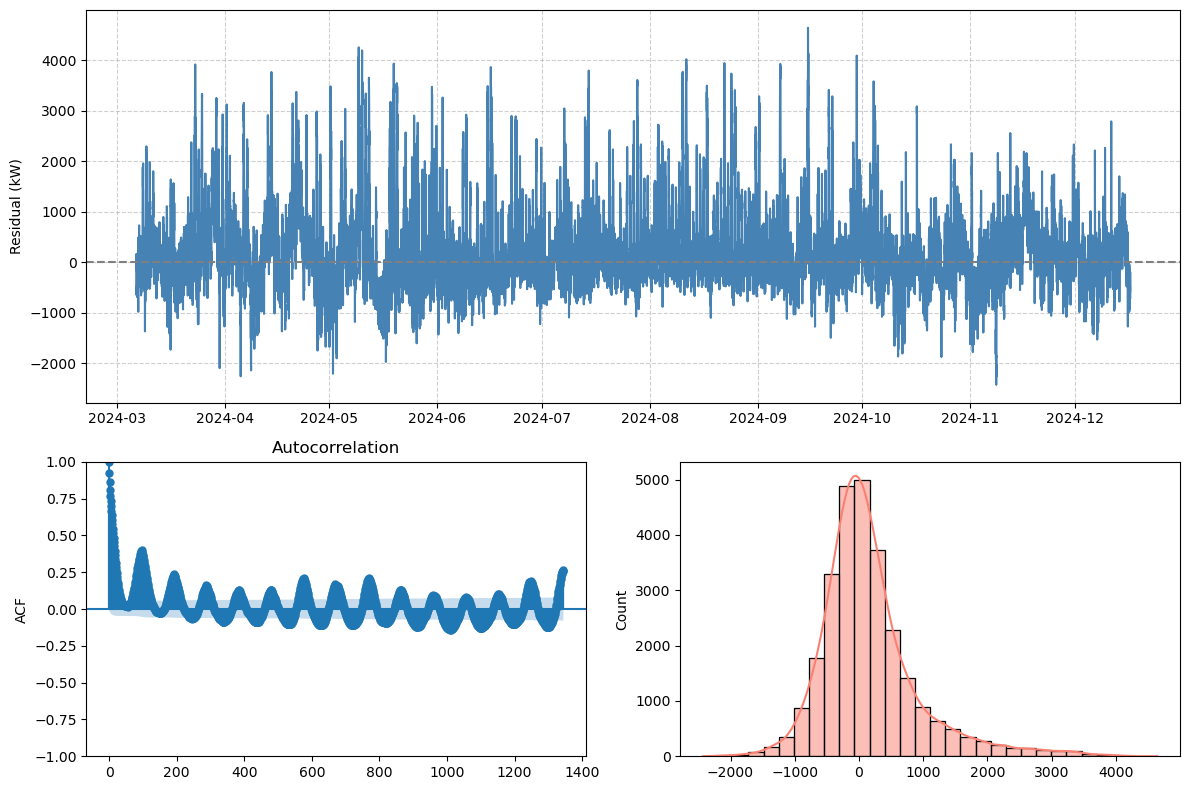

In [20]:
plot_residuals(datetime_lstm_test,
               true_lstm_test,
               pred_lstm_test, 
               filename="residuals(model=lstm,set=test)")

In [21]:
residuals_lstm_test = true_lstm_test - pred_lstm_test
print(acorr_ljungbox(residuals_lstm_test, lags=[192, 1344], return_df=True))

            lb_stat  lb_pvalue
192   326729.184039        0.0
1344  603707.931619        0.0


### Train-time

In [22]:
results_lstm_all = pd.read_csv(
    '/Users/Vageli/Downloads/Results/LSTM_impute_all/predicitions_lstm_all.csv',
    sep=',',
    decimal='.',
    index_col=0,
    parse_dates=True
)

results_lstm_all.index = pd.to_datetime(results_lstm_all.index, utc=True)

datetime_lstm_all = results_lstm_all.index
true_lstm_all = results_lstm_all['true']
pred_lstm_all = results_lstm_all['prediction']

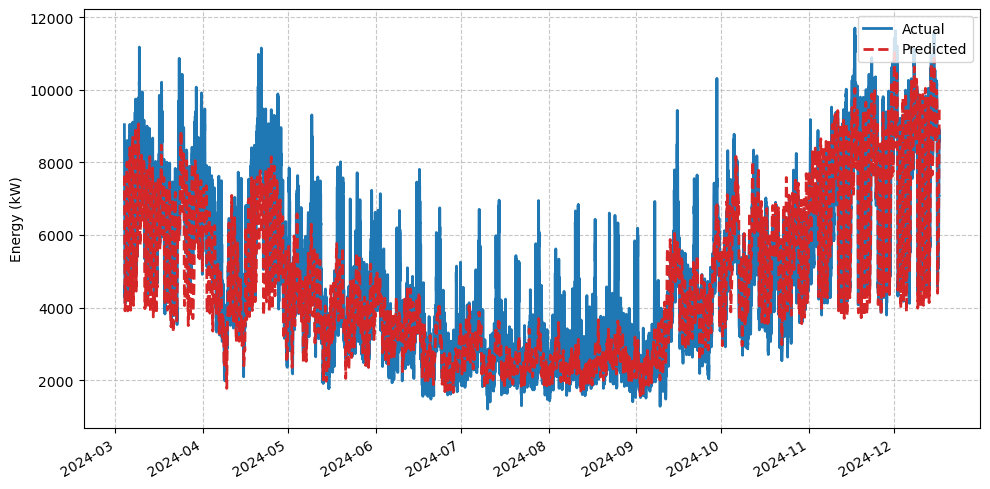

In [23]:
plot_predictions(datetime_lstm_all,
                 true_lstm_all,
                 pred_lstm_all, 
                 color="tab:red",
                 linestyle="dashed",
                 filename="predicitons(model=lstm,set=all)")

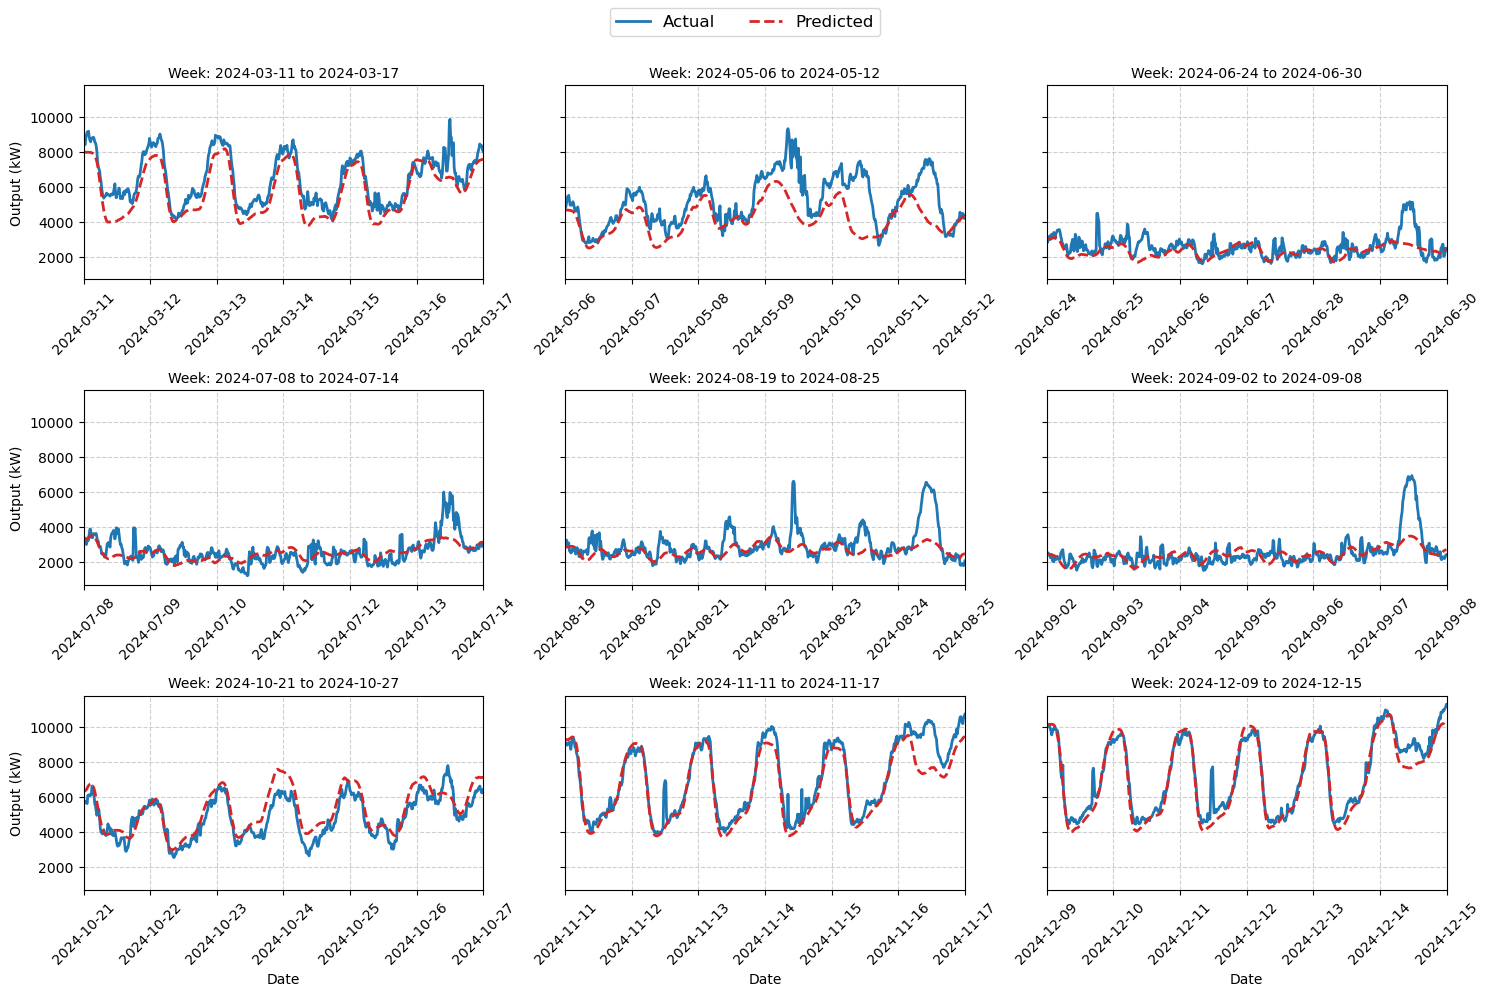

In [24]:
plot_weekly_predictions(datetime_lstm_all,
                        true_lstm_all,
                        pred_lstm_all, 
                        color="tab:red",
                        linestyle="dashed",
                        filename="weekly_intervals(model=lstm,set=all)")

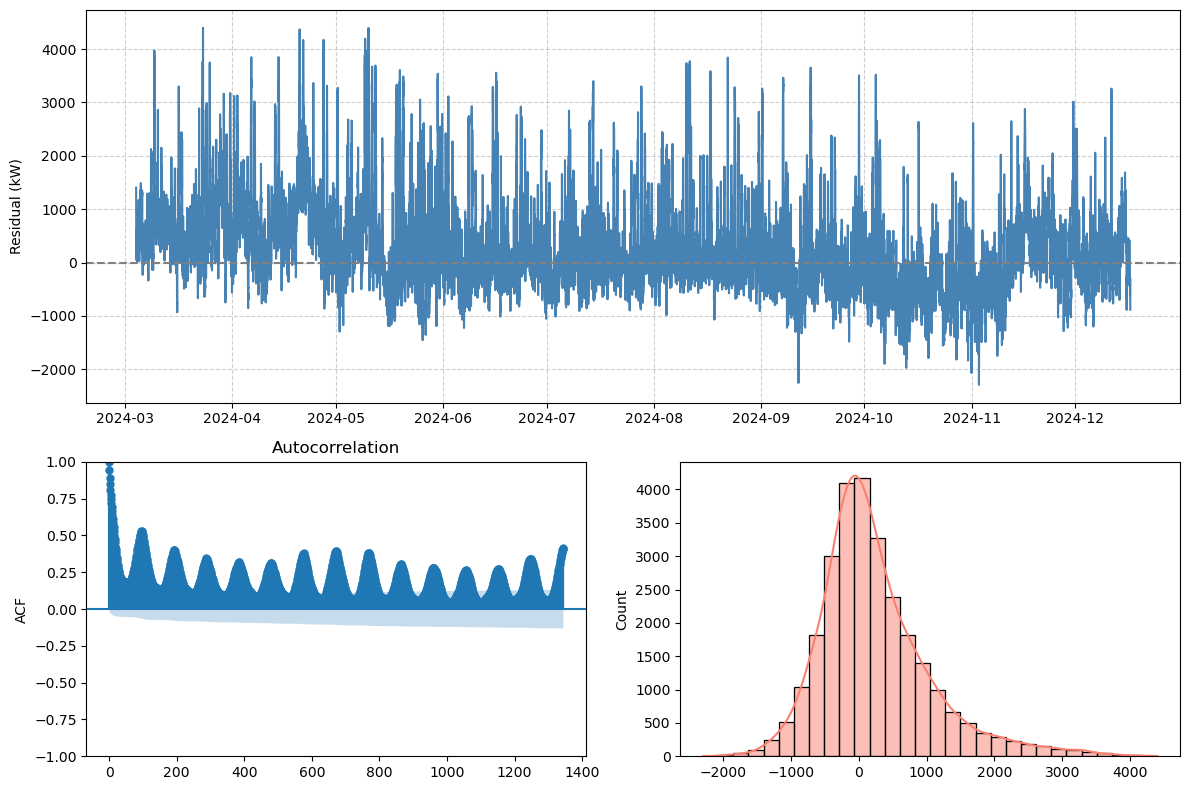

In [25]:
plot_residuals(datetime_lstm_all,
               true_lstm_all,
               pred_lstm_all, 
               filename="residuals(model=lstm,set=all)")

In [26]:
residuals_lstm_all = true_lstm_all - pred_lstm_all
print(acorr_ljungbox(residuals_lstm_all, lags=[192, 1344], return_df=True))

           lb_stat  lb_pvalue
192   6.138298e+05        0.0
1344  1.780581e+06        0.0


## DHR

In [92]:
results_dhr = pd.read_csv(
    '/Users/Vageli/Downloads/dhr_forecast_results_FINAL.csv',
    sep=',',
    decimal='.',
    index_col=0,
    parse_dates=True
)

results_dhr.index = pd.to_datetime(results_dhr.index, utc=True)

datetime_dhr = results_dhr.index
true_dhr = results_dhr['actual']
pred_dhr = results_dhr['forecast']

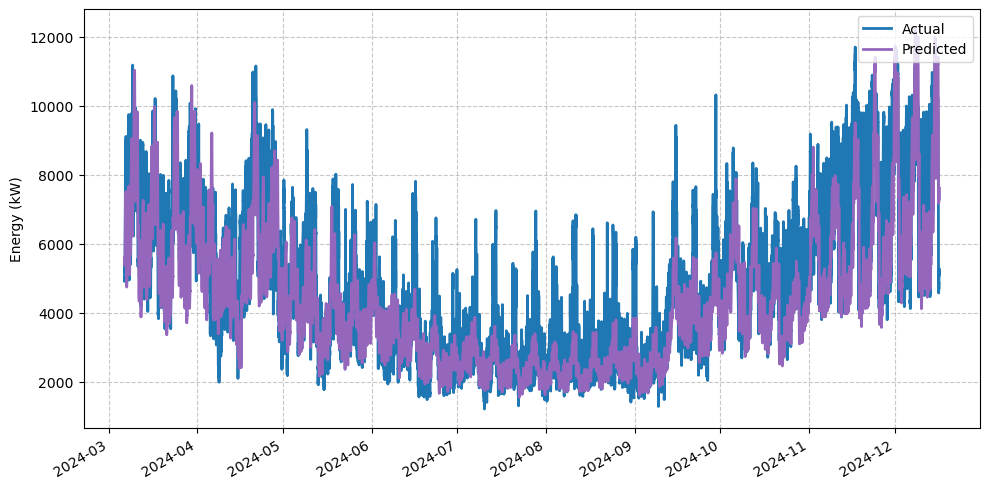

In [96]:
plot_predictions(datetime_dhr,
                 true_dhr,
                 pred_dhr, 
                 color="tab:purple",
                 filename="predicitons(model=dhr)")

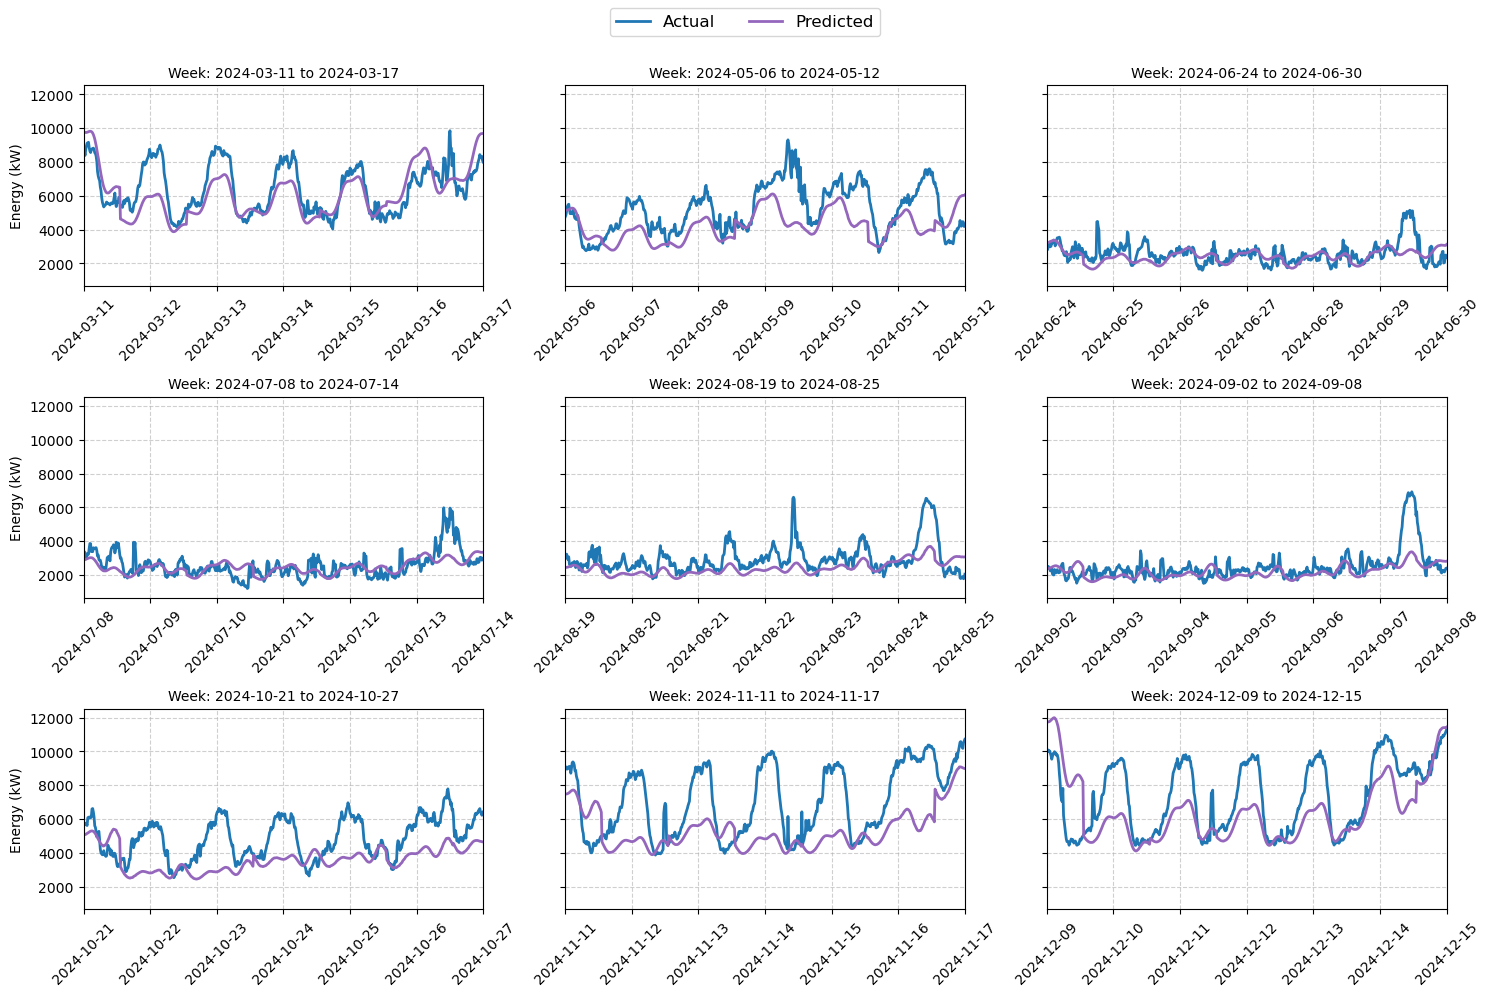

In [97]:
plot_weekly_predictions(datetime_dhr,
                 true_dhr,
                 pred_dhr, 
                 color="tab:purple",
                 filename="predicitons_weekly(model=dhr)")

## Seasonal Naive

In [99]:
results_sn = pd.read_csv(
    '/Users/Vageli/Downloads/seasonal_naive_predictions.csv',
    sep=',',
    decimal='.',
    index_col=0,
    parse_dates=True
)

results_sn.index = pd.to_datetime(results_sn.index, utc=True)

datetime_sn = results_sn.index
true_sn = results_sn['true_output']
pred_sn = results_sn['seasonal_naive_pred']

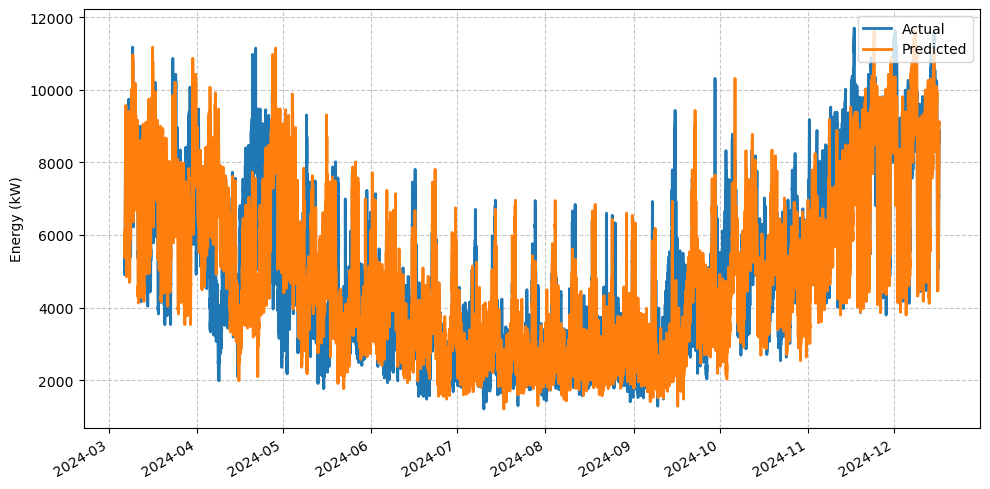

In [100]:
plot_predictions(datetime_sn,
                 true_sn,
                 pred_sn, 
                 color="tab:orange",
                 filename="predicitons(model=sn)")

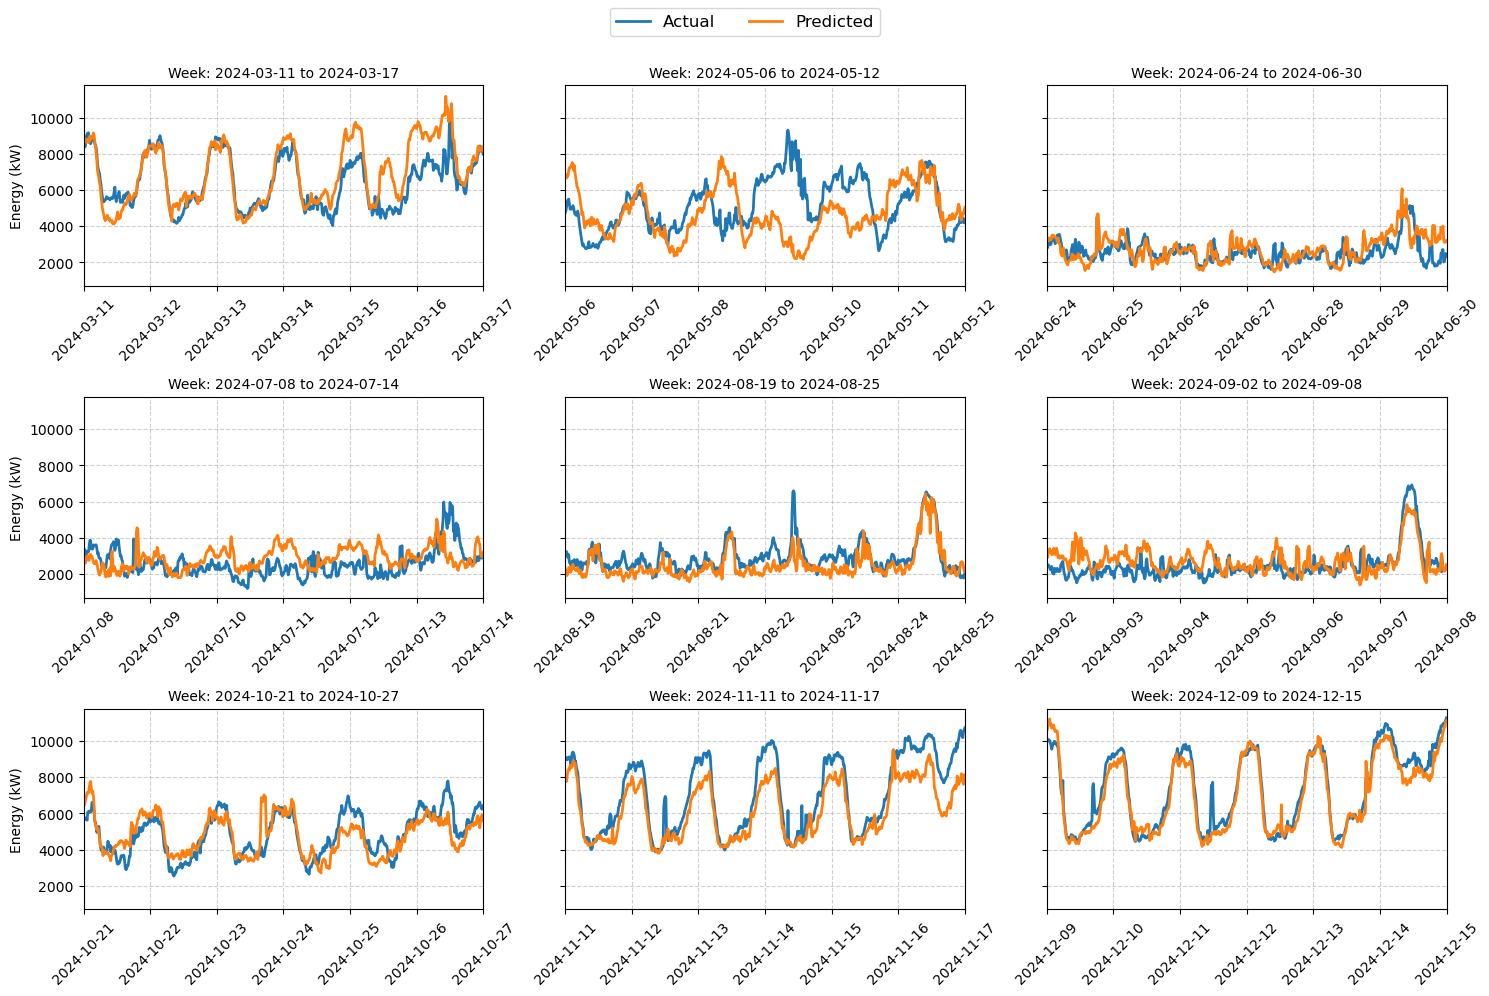

In [101]:
plot_weekly_predictions(datetime_sn,
                 true_sn,
                 pred_sn, 
                 color="tab:orange",
                 filename="predicitons_weekly(model=sn)")

## Other Plots

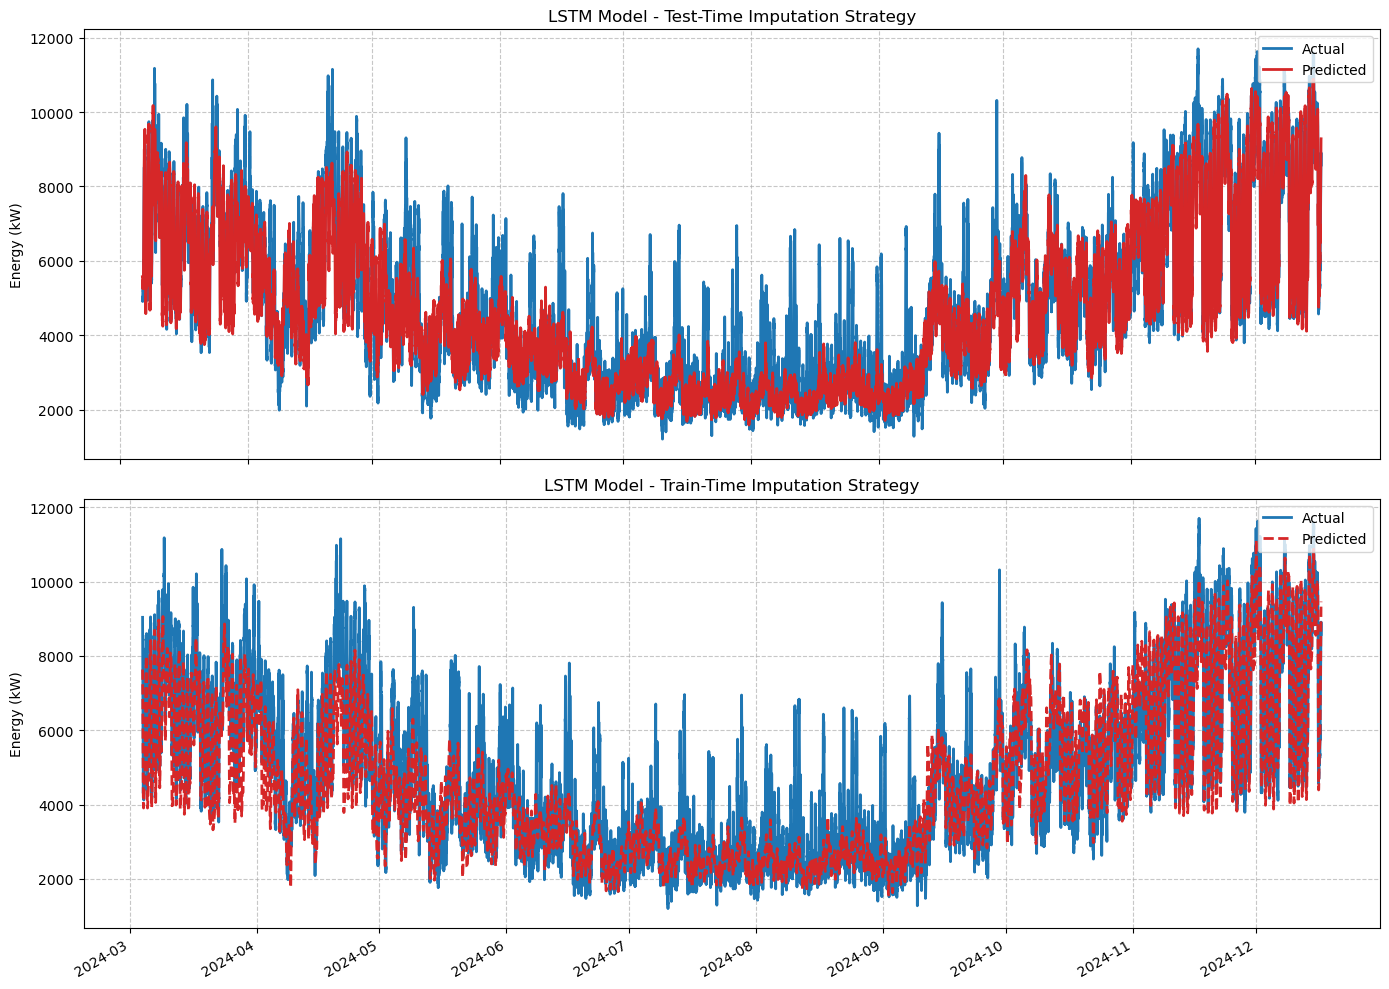

In [38]:
import matplotlib.pyplot as plt

# Create figure with two subplots (vertically stacked)
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharey=True)

# --- Top Plot: LSTM Test Set ---
axes[0].plot(datetime_lstm_test, true_lstm_test, label='Actual', linewidth=2)
axes[0].plot(datetime_lstm_test, pred_lstm_test, label='Predicted', color='tab:red', linewidth=2)
axes[0].set_title('LSTM Model - Test-Time Imputation Strategy')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(loc='upper right')

# --- Bottom Plot: LSTM All Set (Dashed Line) ---
axes[1].plot(datetime_lstm_all, true_lstm_all, label='Actual', linewidth=2)
axes[1].plot(datetime_lstm_all, pred_lstm_all, label='Predicted', color='tab:red', linestyle='dashed', linewidth=2)
axes[1].set_title('LSTM Model - Train-Time Imputation Strategy')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(loc='upper right')

# Labels
axes[0].set_ylabel("Energy (kW)")
axes[1].set_ylabel("Energy (kW)")

# Auto-format x-axis labels
fig.autofmt_xdate()

plt.tight_layout()
plt.savefig("/Users/Vageli/Desktop/DABN01/plots/Results/LSTM_predictions_combined.png", dpi=300)
plt.show()

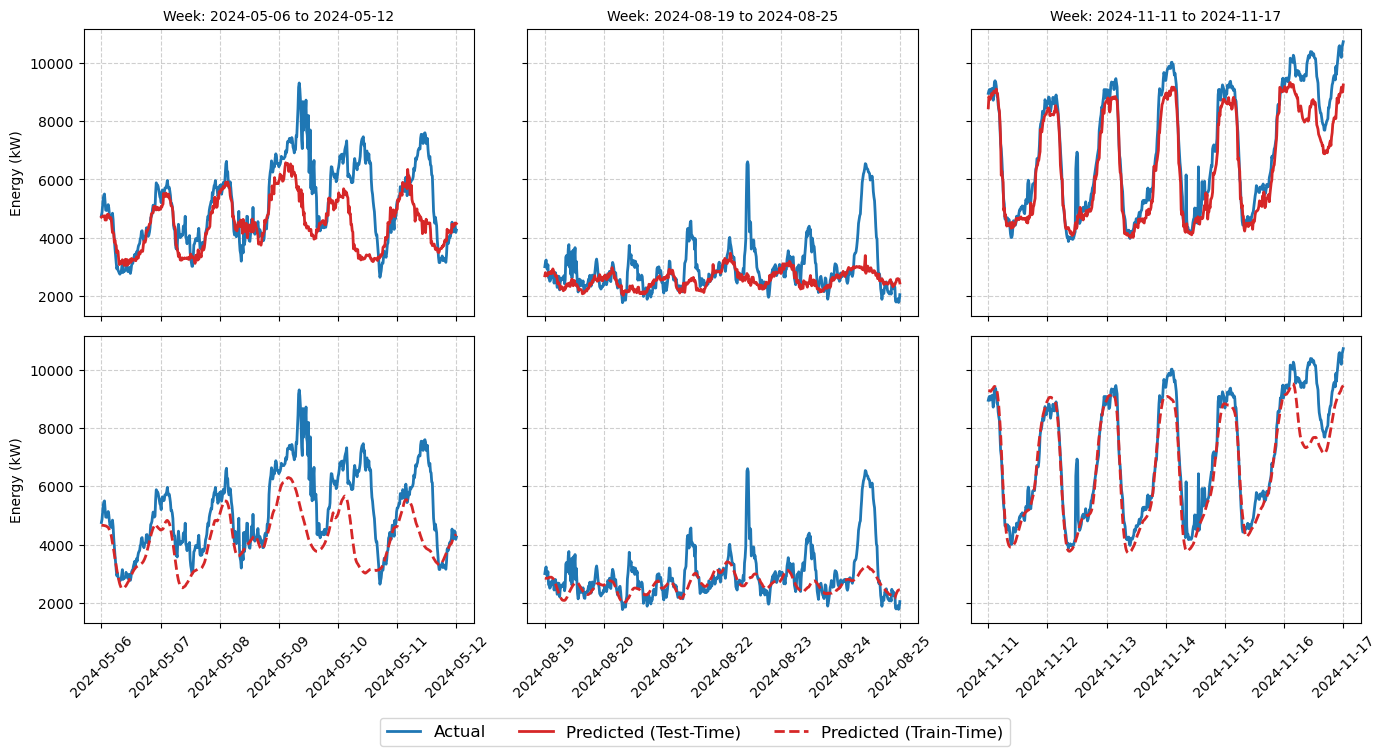

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Define fixed weeks
weeks = [
    ('2024-05-06', '2024-05-12'),
    ('2024-08-19', '2024-08-25'),
    ('2024-11-11', '2024-11-17')
]

# Get timezone
tz = datetime_lstm_test.tz

# Convert to timezone-aware timestamps
weeks = [(pd.Timestamp(start).tz_localize(tz), pd.Timestamp(end).tz_localize(tz)) for start, end in weeks]

# Create figure and axes
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharey=True)

# Row 1: LSTM Test
for ax, (start_date, end_date) in zip(axes[0], weeks):
    mask = (datetime_lstm_test >= start_date) & (datetime_lstm_test <= end_date)
    l1, = ax.plot(datetime_lstm_test[mask], true_lstm_test[mask], label='Actual', linewidth=2)
    l2, = ax.plot(datetime_lstm_test[mask], pred_lstm_test[mask], label='Predicted (Test)', color='tab:red', linewidth=2)
    ax.set_title(f'Week: {start_date.date()} to {end_date.date()}', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', labelbottom=False)

# Row 2: LSTM All
for ax, (start_date, end_date) in zip(axes[1], weeks):
    mask = (datetime_lstm_all >= start_date) & (datetime_lstm_all <= end_date)
    l3, = ax.plot(datetime_lstm_all[mask], true_lstm_all[mask], label='Actual', linewidth=2)
    l4, = ax.plot(datetime_lstm_all[mask], pred_lstm_all[mask], label='Predicted (All)', color='tab:red', linestyle='dashed', linewidth=2)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', labelrotation=45)

# Remove x-axis label
for ax in axes[1]:
    ax.set_xlabel("")

# Y-axis labels
axes[0, 0].set_ylabel("Energy (kW)")
axes[1, 0].set_ylabel("Energy (kW)")

# Single legend at the bottom center
fig.legend([l1, l2, l4], ['Actual', 'Predicted (Test-Time)', 'Predicted (Train-Time)'],
           loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig("/Users/Vageli/Desktop/DABN01/plots/Results/LSTM_weekly_predictions_combined.png", dpi=300)
plt.show()

In [82]:
# Step 1: Merge LGBM test and all (keep true from LGBM test)
results_combined = results_lgbm_test[['true', 'prediction']].merge(
    results_lgbm_all[['prediction']], 
    left_index=True, 
    right_index=True, 
    how='inner', 
    suffixes=('_lgbm_test', '_lgbm_all')
)

# Step 2: Merge LSTM test
results_combined = results_combined.merge(
    results_lstm_test[['prediction']], 
    left_index=True, 
    right_index=True, 
    how='inner'
)
results_combined = results_combined.rename(columns={'prediction': 'prediction_lstm_test'})

# Step 3: Merge LSTM all
results_combined = results_combined.merge(
    results_lstm_all[['prediction']], 
    left_index=True, 
    right_index=True, 
    how='inner'
)
results_combined = results_combined.rename(columns={'prediction': 'prediction_lstm_all'})

# Step 4: Rename the true column for clarity
results_combined = results_combined.rename(columns={'true': 'true_lgbm'})

# Sort index
results_combined = results_combined.sort_index()

# Final preview
print(results_combined.head())

                           true_lgbm  prediction_lgbm_test  \
datetime                                                     
2024-03-06 13:15:00+00:00   5019.920           5599.982202   
2024-03-06 13:30:00+00:00   4936.712           5431.273776   
2024-03-06 13:45:00+00:00   4920.076           5423.315313   
2024-03-06 14:00:00+00:00   4905.044           5436.810407   
2024-03-06 14:15:00+00:00   5076.048           5418.152268   

                           prediction_lgbm_all  prediction_lstm_test  \
datetime                                                               
2024-03-06 13:15:00+00:00          5625.308451             5579.1714   
2024-03-06 13:30:00+00:00          5482.129017             5579.7630   
2024-03-06 13:45:00+00:00          5482.129017             5402.6620   
2024-03-06 14:00:00+00:00          5482.129017             5456.1177   
2024-03-06 14:15:00+00:00          5482.129017             5469.6665   

                           prediction_lstm_all  
datetime   

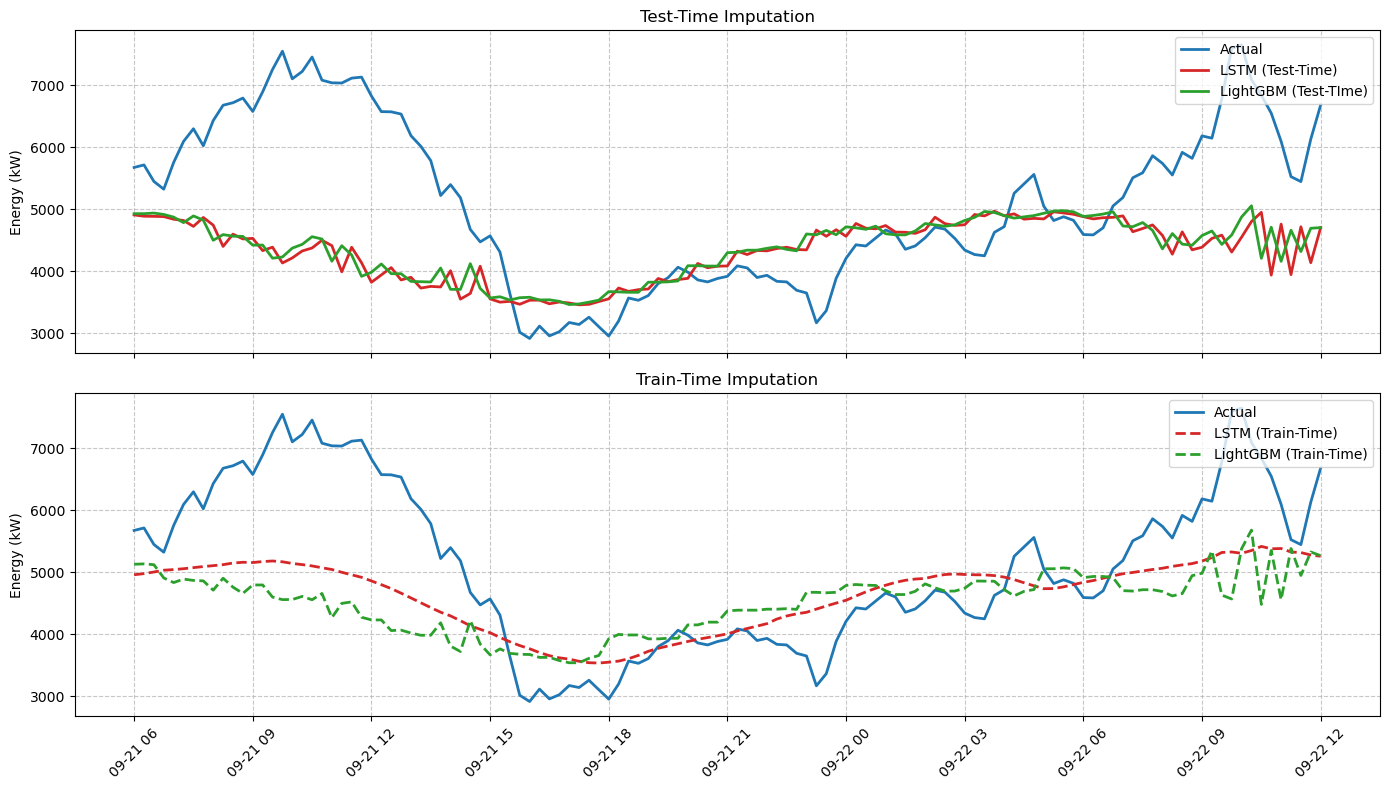

In [91]:
import matplotlib.pyplot as plt
import pandas as pd

# Define time range (timezone-aware, assuming UTC from pd.to_datetime)
start = pd.Timestamp('2024-09-21 06:00:00', tz='UTC')
end = pd.Timestamp('2024-09-22 12:00:00', tz='UTC')

# Create mask for time window
mask = (results_combined.index >= start) & (results_combined.index <= end)

# Create figure with two rows of subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- Row 1: LGBM Test + LSTM Test ---
axes[0].plot(results_combined.index[mask], results_combined['true_lgbm'][mask], label='Actual', linewidth=2)
axes[0].plot(results_combined.index[mask], results_combined['prediction_lstm_test'][mask], label='LSTM (Test-Time)', color='tab:red', linewidth=2)
axes[0].plot(results_combined.index[mask], results_combined['prediction_lgbm_test'][mask], label='LightGBM (Test-TIme)', color='tab:green', linewidth=2)
axes[0].set_ylabel('Energy (kW)')
axes[0].legend(loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_title("Test-Time Imputation")

# --- Row 2: LGBM All + LSTM All ---
axes[1].plot(results_combined.index[mask], results_combined['true_lgbm'][mask], label='Actual', linewidth=2)
axes[1].plot(results_combined.index[mask], results_combined['prediction_lstm_all'][mask], label='LSTM (Train-Time)', color='tab:red', linestyle='dashed', linewidth=2)
axes[1].plot(results_combined.index[mask], results_combined['prediction_lgbm_all'][mask], label='LightGBM (Train-Time)', color='tab:green', linestyle='dashed', linewidth=2)
axes[1].set_ylabel('Energy (kW)')
axes[1].legend(loc='upper right')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_title("Train-Time Imputation")

# X-axis formatting
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
plt.savefig("/Users/Vageli/Desktop/DABN01/plots/Results/LSTM_vs_LGBM.png", dpi=300)
plt.show()

In [71]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
    x=results_combined.index, 
    y=results_combined['true_lgbm'], 
    mode='lines', 
    name='Actual'
))

fig.add_trace(go.Scatter(
    x=results_combined.index, 
    y=results_combined['prediction_lstm'], 
    mode='lines', 
    name='LSTM', 
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=results_combined.index, 
    y=results_combined['prediction_lgbm'], 
    mode='lines', 
    name='LightGBM', 
    line=dict(color='green')
))

# Layout
fig.update_layout(
    title="Predictions vs Actual - Test Period",
    xaxis_title="Datetime",
    yaxis_title="Energy Output (kW)",
    height=500,
    width=1000,
    legend=dict(x=0, y=1.1, orientation='h'),
    margin=dict(l=40, r=40, t=40, b=40)
)

# Show plot
fig.show()

In [102]:
from PIL import Image

# --- 1. open the two images -----------------------------
upper = Image.open('/Users/Vageli/Downloads/Results/LSTM_impute_test/Plots/training_history(set=test).png')
lower = Image.open('/Users/Vageli/Downloads/Results/LSTM_impute_all/Plots/training_history(set=all).png')

# --- 2. match their widths (preserve aspect ratio) ------
if upper.width != lower.width:
    common = min(upper.width, lower.width)
    upper = upper.resize((common,
                          int(upper.height * common / upper.width)),
                         Image.LANCZOS)
    lower = lower.resize((common,
                          int(lower.height * common / lower.width)),
                         Image.LANCZOS)

# --- 3. create a blank canvas and paste -----------------
h = upper.height + lower.height
combined = Image.new('RGB', (upper.width, h), 'white')
combined.paste(upper, (0, 0))
combined.paste(lower, (0, upper.height))

# --- 4. save it -----------------------------------------
combined.save('combined_training_history.png')

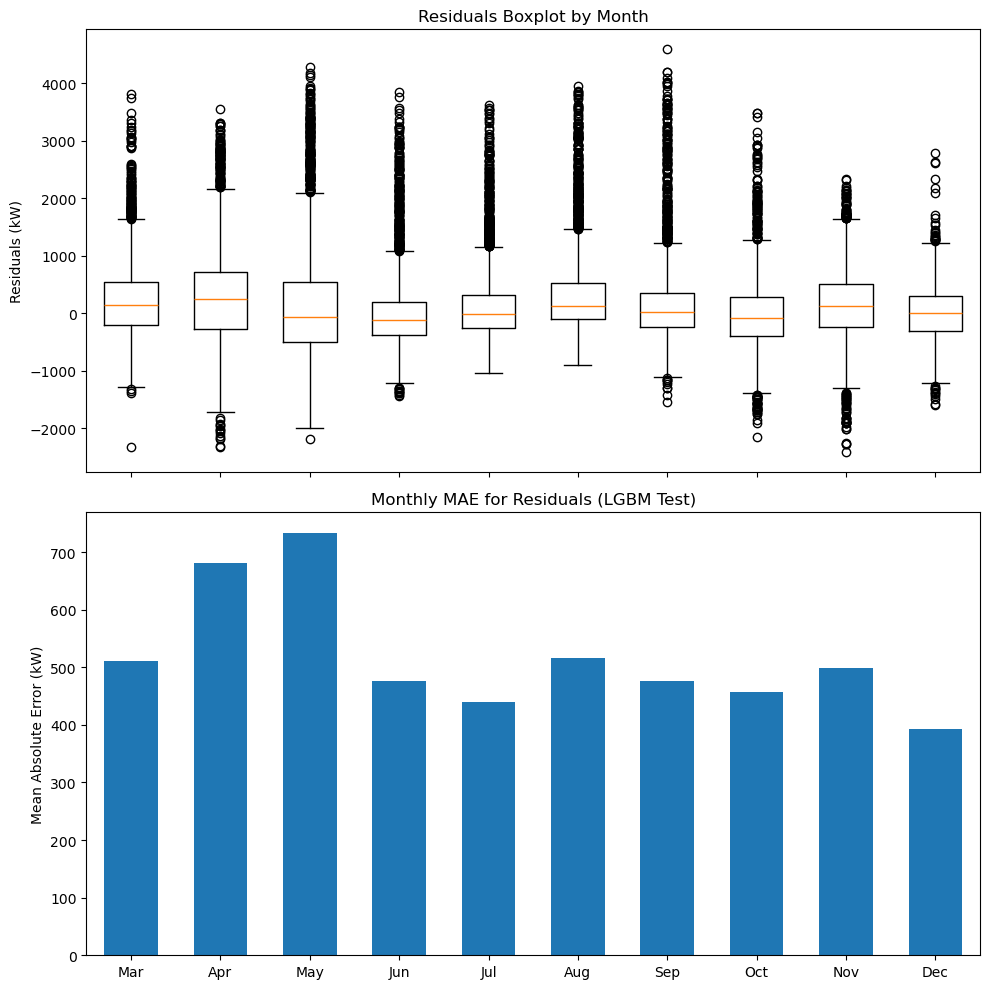

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# --- Calculate Residuals ---
residuals_lgbm_test = true_lgbm_test - pred_lgbm_test

# --- Prepare Data ---

# Month numbers and labels (March to December)
months = np.arange(3, 13)
month_labels = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Group residuals for boxplot
monthly_groups = [residuals_lgbm_test[residuals_lgbm_test.index.month == m] for m in months]

# Calculate MAE per month
mae_by_month = residuals_lgbm_test.groupby(residuals_lgbm_test.index.month).apply(lambda x: np.mean(np.abs(x)))
mae_by_month = mae_by_month.loc[months]

# --- Plot Combined Figure ---
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Boxplot (top)
axes[0].boxplot(monthly_groups, positions=np.arange(len(month_labels)) + 1, widths=0.6, showfliers=True)
axes[0].set_ylabel('Residuals (kW)')
axes[0].set_title('Residuals Boxplot by Month')
axes[0].set_xticks(np.arange(1, len(month_labels) + 1))
axes[0].set_xticklabels(month_labels)

# Barplot (bottom)
axes[1].bar(np.arange(1, len(month_labels) + 1), mae_by_month.values, color='tab:blue', width=0.6)
axes[1].set_ylabel('Mean Absolute Error (kW)')
axes[1].set_title('Monthly MAE for Residuals (LGBM Test)')
axes[1].set_xticks(np.arange(1, len(month_labels) + 1))
axes[1].set_xticklabels(month_labels)

plt.tight_layout()

# Save and show
# plt.savefig("/Users/Vageli/Desktop/DABN01/plots/Results/LightGBM/residual_box_bar_lgbm", dpi=300)
plt.show()

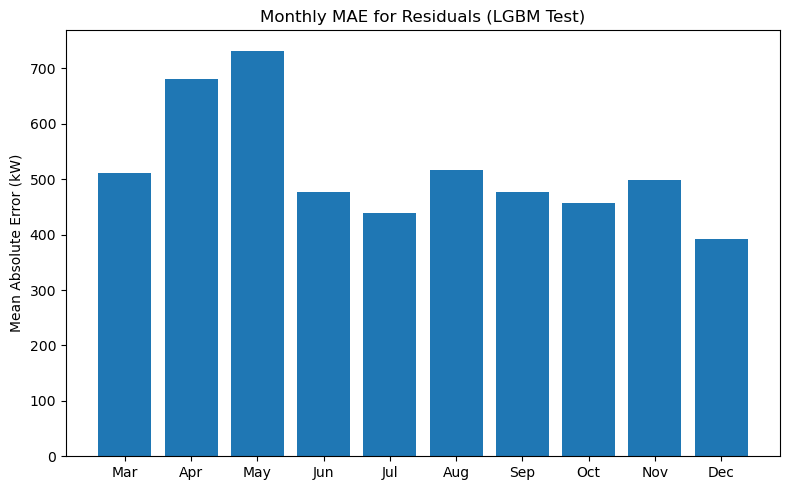

In [106]:
import numpy as np

# Calculate residuals
residuals_lgbm_test = true_lgbm_test - pred_lgbm_test

# Calculate MAE per month (March to December)
mae_by_month = residuals_lgbm_test.groupby(residuals_lgbm_test.index.month).apply(lambda x: np.mean(np.abs(x)))
mae_by_month = mae_by_month.loc[3:12]  # March to December

# Month labels
month_labels = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(month_labels, mae_by_month.values, color='tab:blue')

plt.ylabel('Mean Absolute Error (kW)')
plt.title('Monthly MAE for Residuals (LGBM Test)')
plt.tight_layout()

# Save and show
plt.show()

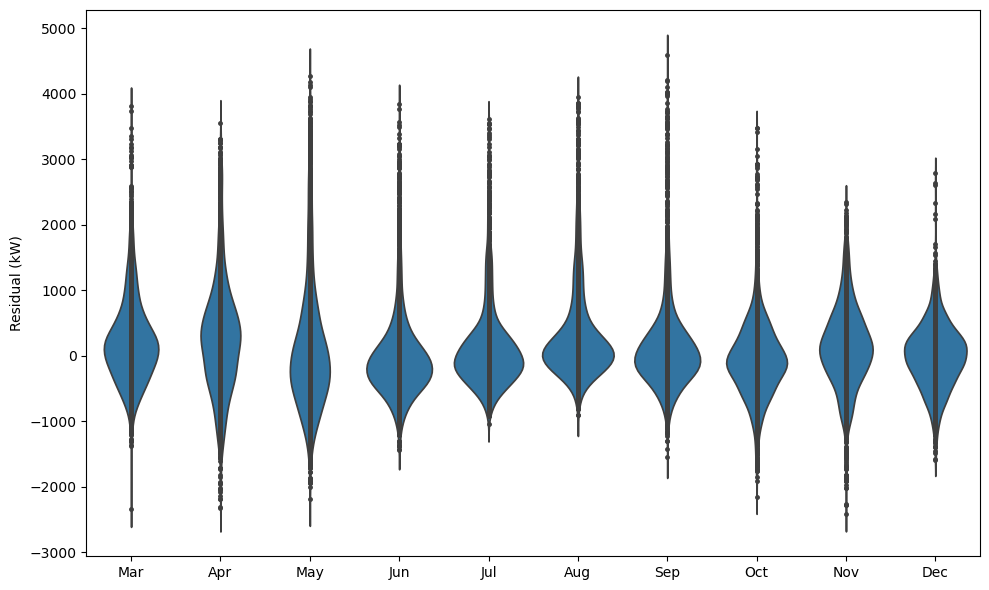

In [114]:
import seaborn as sns
import calendar

# --- Prepare Data ---
residuals_lgbm_test = true_lgbm_test - pred_lgbm_test

# DataFrame with residuals and months (March–December)
residuals_df = pd.DataFrame({
    'residual': residuals_lgbm_test
})
residuals_df['month'] = residuals_df.index.month
residuals_df = residuals_df[(residuals_df['month'] >= 3) & (residuals_df['month'] <= 12)]
residuals_df['month_name'] = residuals_df['month'].apply(lambda x: calendar.month_abbr[x])

# --- Violin Plot ---
plt.figure(figsize=(10, 6))
sns.violinplot(x='month_name', y='residual', data=residuals_df, order=['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], inner='point')

plt.ylabel('Residual (kW)')
plt.xlabel('')
plt.tight_layout()

# Save plot
plt.savefig("/Users/Vageli/Desktop/DABN01/plots/Results/LightGBM/residual_violin_lgbm", dpi=300)
plt.show()
